# training on existing Data

In [1]:
import numpy as np
import cv2 
import os
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import pandas as pd

2022-04-01 19:46:05.735730: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mina/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-01 19:46:05.735747: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
actions = ['one','you','teacher','girl','tomorrow','mom','look','crazy','walk','agree']

In [3]:
actions

['one',
 'you',
 'teacher',
 'girl',
 'tomorrow',
 'mom',
 'look',
 'crazy',
 'walk',
 'agree']

In [4]:
train_data = np.concatenate([
    np.load(os.path.join("key_points",'train','0.npy')),
    np.load(os.path.join("key_points",'train','1.npy')),
    np.load(os.path.join("key_points",'train','2.npy')),
    np.load(os.path.join("key_points",'train','3.npy')),
    np.load(os.path.join("key_points",'train','4.npy')),
    np.load(os.path.join("key_points",'train','5.npy')),
])

train_labels = np.concatenate([
    np.load(os.path.join("key_points",'train','labels.npy')),
    np.load(os.path.join("key_points",'train','labels.npy')),
    np.load(os.path.join("key_points",'train','labels.npy')),
    np.load(os.path.join("key_points",'train','labels.npy')),
    np.load(os.path.join("key_points",'train','labels.npy')),
    np.load(os.path.join("key_points",'train','labels.npy')),
])


test_data   = np.load(os.path.join("key_points","test",'data.npy')) 
test_labels = np.load(os.path.join("key_points","test",'labels.npy'))  



print(
train_data.shape,
    train_labels.shape,
    test_data.shape,
    test_labels.shape
    
)

(5154, 16, 62) (5154,) (99, 16, 62) (99,)


In [5]:
perm = np.random.permutation(len(train_data))

train_X = train_data[perm]
train_Y = train_labels[perm]
test_X = test_data
test_Y = test_labels

print(
train_X.shape,
train_Y.shape,
test_X.shape,
test_Y.shape,
)


(5154, 16, 62) (5154,) (99, 16, 62) (99,)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping

# v1 ->95% training , 88% validation,84% test
# v1 =  os.path.join("final_train_weights","first_model_V1.h5")
best_model_file_name = os.path.join("weights","pretrain2.h5")


checkpoint = ModelCheckpoint(os.path.join(best_model_file_name), monitor='loss', verbose=0,
    save_best_only=True, mode='auto', save_freq=1)
earlyStopping = EarlyStopping(monitor='loss', patience=20)

In [7]:
def first_model():
    input_layer = Input(shape=(20,62))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(256,return_sequences=True,activation="relu")(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


def second_model():
    input_layer = Input(shape=(20,62))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(256,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = Dropout(0.5)(layer)
    layer = LSTM(64,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    
    return model

def third_model():
    input_layer = Input(shape=(16,62))
    layer = LSTM(64,return_sequences=True,activation="relu")(input_layer)
    layer = LSTM(128,return_sequences=True,activation="relu")(layer)
    layer = LSTM(96,return_sequences=False,activation="relu")(layer)
    layer = Dense(64,activation="relu")(layer)
    layer = Dense(len(actions),activation="softmax")(layer)

#     optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002,
#                              beta_1=0.9,
#                              beta_2=0.999, 
#                              epsilon=1e-08,
#                              schedule_decay=0.004)
    
    model = Model(inputs=input_layer,outputs=layer)
    model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = third_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 62)]          0         
                                                                 
 lstm (LSTM)                 (None, 16, 64)            32512     
                                                                 
 lstm_1 (LSTM)               (None, 16, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 96)                86400     
                                                                 
 dense (Dense)               (None, 64)                6208      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 224,586
Trainable params: 224,586
Non-trainable

2022-04-01 19:46:28.959756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 19:46:28.960069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mina/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-01 19:46:28.960109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mina/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-01 19:46:28.960142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublas

In [9]:
model.load_weights(os.path.join("weights","V1.h5"))

In [10]:
history = model.fit(train_X, train_Y, epochs=100, callbacks=[checkpoint,earlyStopping],validation_data=(test_X,test_Y),batch_size=16)

Epoch 1/100
323/323 [==============================] - 12s 33ms/step - loss: 1.4766 - accuracy: 0.4992 - val_loss: 1.3158 - val_accuracy: 0.4949
Epoch 2/100
323/323 [==============================] - 4s 12ms/step - loss: 0.9544 - accuracy: 0.6467 - val_loss: 1.0132 - val_accuracy: 0.6364
Epoch 3/100
323/323 [==============================] - 5s 16ms/step - loss: 0.7234 - accuracy: 0.7247 - val_loss: 0.9186 - val_accuracy: 0.6667
Epoch 4/100
323/323 [==============================] - 4s 12ms/step - loss: 0.6022 - accuracy: 0.7646 - val_loss: 1.2234 - val_accuracy: 0.6667
Epoch 5/100
323/323 [==============================] - 4s 11ms/step - loss: 0.4990 - accuracy: 0.8120 - val_loss: 0.9995 - val_accuracy: 0.6869
Epoch 6/100
323/323 [==============================] - 4s 11ms/step - loss: 0.4817 - accuracy: 0.8273 - val_loss: 1.1834 - val_accuracy: 0.6768
Epoch 7/100
323/323 [==============================] - 4s 12ms/step - loss: 0.3501 - accuracy: 0.8708 - val_loss: 1.5076 - val_accuracy

323/323 [==============================] - 4s 13ms/step - loss: 0.0081 - accuracy: 0.9979 - val_loss: 2.1110 - val_accuracy: 0.7677
Epoch 58/100
323/323 [==============================] - 4s 12ms/step - loss: 0.1037 - accuracy: 0.9682 - val_loss: 1.8127 - val_accuracy: 0.7980
Epoch 59/100
323/323 [==============================] - 4s 12ms/step - loss: 0.0469 - accuracy: 0.9843 - val_loss: 1.8488 - val_accuracy: 0.7374
Epoch 60/100
323/323 [==============================] - 4s 12ms/step - loss: 0.0748 - accuracy: 0.9757 - val_loss: 1.7070 - val_accuracy: 0.7778
Epoch 61/100
323/323 [==============================] - 4s 13ms/step - loss: 0.0871 - accuracy: 0.9740 - val_loss: 1.2125 - val_accuracy: 0.7475
Epoch 62/100
323/323 [==============================] - 4s 12ms/step - loss: 0.0682 - accuracy: 0.9806 - val_loss: 1.1574 - val_accuracy: 0.7980
Epoch 63/100
323/323 [==============================] - 4s 12ms/step - loss: 0.1170 - accuracy: 0.9593 - val_loss: 0.9755 - val_accuracy: 0.798

In [33]:
m2 = third_model()
m2.load_weights(os.path.join(best_model_file_name))
print(
    m2.evaluate(train_X,train_Y),
    m2.evaluate(val_X,val_Y),
    m2.evaluate(test_X,test_Y)
)

6/6 [==============================] - 0s 11ms/step - loss: 0.4650 - accuracy: 0.8690
[0.0862136259675026, 0.9713364839553833] [0.39432308077812195, 0.9263157844543457] [0.46498429775238037, 0.8690476417541504]


In [11]:
model.save_weights(os.path.join(best_model_file_name))

In [8]:
model.load_weights(os.path.join(best_model_file_name))

# evaluation


- write matplotlib code to display both of them
- then write function to display history and evaluation just one time

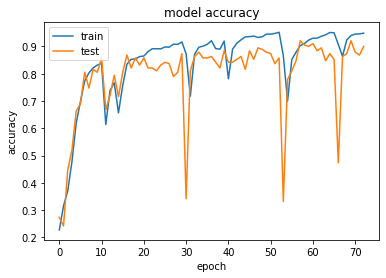

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

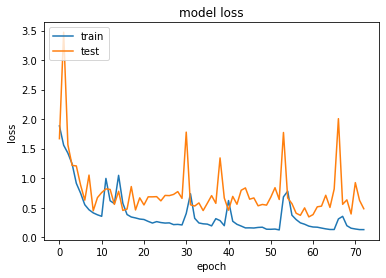

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
print(
    model.evaluate(train_X,train_Y),
    model.evaluate(val_X,val_Y),
    model.evaluate(test_X,test_Y)
)

6/6 [==============================] - 0s 7ms/step - loss: 0.6367 - accuracy: 0.9107
[0.0105246901512146, 0.99620121717453] [0.4720112383365631, 0.9263157844543457] [0.6367243528366089, 0.9107142686843872]


In [9]:
model = third_model()
model.load_weights(os.path.join("final_train_weights","third_model_V1.h5"))

In [10]:
for desired_class in range(10):
    x = []
    y = [] 
    for i,n in enumerate(val_Y):
        if n==desired_class:
            x.append(val_X[i])
            y.append(n)

    x = np.array(x)
    y = np.array(y)
    print(f"class : {desired_class}:{actions[desired_class]} -->",model.evaluate(x,y,verbose=0))
        

class : 0:sister --> [1.7010161876678467, 0.800000011920929]
class : 1:hurry --> [0.0001951986487256363, 1.0]
class : 2:hungry --> [0.00013828328519593924, 1.0]
class : 3:meal --> [0.1749543994665146, 0.9473684430122375]
class : 4:brother --> [0.7396684885025024, 0.8500000238418579]
class : 5:tree --> [0.2636032998561859, 0.8999999761581421]
class : 6:heavy --> [1.7032395601272583, 0.8461538553237915]
class : 7:cry --> [0.13189388811588287, 0.949999988079071]
class : 8:family --> [2.2531592549057677e-05, 1.0]
class : 9:wise --> [0.39396458864212036, 0.9473684430122375]


In [23]:
model = first_model()
model.load_weights(os.path.join("final_train_weights","first_model_V1.h5"))

In [24]:

for desired_class in range(10):
    x = []
    y = [] 
    for i,n in enumerate(val_Y):
        if n==desired_class:
            x.append(val_X[i])
            y.append(n)

    x = np.array(x)
    y = np.array(y)
    print(f"class : {desired_class}:{actions[desired_class]} -->",model.evaluate(x,y,verbose=0))
        

class : 0:sister --> [2.1439902782440186, 0.699999988079071]
class : 1:hurry --> [0.4425128996372223, 0.7894737124443054]
class : 2:hungry --> [0.23317945003509521, 0.8999999761581421]
class : 3:meal --> [0.05305203050374985, 0.9473684430122375]
class : 4:brother --> [0.9514178037643433, 0.699999988079071]
class : 5:tree --> [0.7925909757614136, 0.8500000238418579]
class : 6:heavy --> [0.0105934152379632, 1.0]
class : 7:cry --> [0.003288751933723688, 1.0]
class : 8:family --> [3.0288221751106903e-05, 1.0]
class : 9:wise --> [0.17635352909564972, 0.8947368264198303]


In [21]:
model = first_model()
model.load_weights(os.path.join("final_train_weights","first_model_V2.h5"))

In [22]:

for desired_class in range(10):
    x = []
    y = [] 
    for i,n in enumerate(val_Y):
        if n==desired_class:
            x.append(val_X[i])
            y.append(n)

    x = np.array(x)
    y = np.array(y)
    print(f"class : {desired_class}:{actions[desired_class]} -->",model.evaluate(x,y,verbose=0))
        

class : 0:sister --> [0.825576663017273, 0.8500000238418579]
class : 1:hurry --> [0.01183120533823967, 1.0]
class : 2:hungry --> [0.11262451112270355, 0.949999988079071]
class : 3:meal --> [0.5067373514175415, 0.8947368264198303]
class : 4:brother --> [1.662697434425354, 0.800000011920929]
class : 5:tree --> [0.34248995780944824, 0.8999999761581421]
class : 6:heavy --> [0.028256479650735855, 1.0]
class : 7:cry --> [0.06529584527015686, 1.0]
class : 8:family --> [0.0009215319296345115, 1.0]
class : 9:wise --> [0.23732376098632812, 0.8947368264198303]


In [ ]:
model = second_model()
model.load_weights(os.path.join("final_train_weights","second_model_V1.h5"))

In [18]:

for desired_class in range(10):
    x = []
    y = [] 
    for i,n in enumerate(val_Y):
        if n==desired_class:
            x.append(val_X[i])
            y.append(n)

    x = np.array(x)
    y = np.array(y)
    print(f"class : {desired_class}:{actions[desired_class]} -->",model.evaluate(x,y,verbose=0))
        

class : 0:sister --> [1.455183744430542, 0.75]
class : 1:hurry --> [0.24843087792396545, 0.8421052694320679]
class : 2:hungry --> [1.4502105712890625, 0.75]
class : 3:meal --> [0.39883410930633545, 0.8947368264198303]
class : 4:brother --> [0.8388317823410034, 0.800000011920929]
class : 5:tree --> [1.0407341718673706, 0.800000011920929]
class : 6:heavy --> [0.010108273476362228, 1.0]
class : 7:cry --> [0.0016583595424890518, 1.0]
class : 8:family --> [0.005287606734782457, 1.0]
class : 9:wise --> [0.2445170283317566, 0.9473684430122375]
